### Задание

In [1]:
import torch
import torch.nn as nn
torch.manual_seed(0)
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

1. Повторите шаги 1-4 из предыдущего задания со следующими изменениями:

- ширину окна $k$ из задания 3 положите равной 4;
- размерность `X` на выходе: (размер выборки, ширина окна `k`, 1).

In [2]:
df=pd.read_csv('passengers.csv',index_col='date')
df

,num_passengers
date,
1949-1-1,112
1949-2-1,118
1949-3-1,132
1949-4-1,129
1949-5-1,121
...,...
1960-8-1,606
1960-9-1,508
1960-10-1,461


In [3]:
df['num_passengers']=df['num_passengers'].astype(np.float32)
df

,num_passengers
date,
1949-1-1,112.0
1949-2-1,118.0
1949-3-1,132.0
1949-4-1,129.0
1949-5-1,121.0
...,...
1960-8-1,606.0
1960-9-1,508.0
1960-10-1,461.0


In [4]:
scaler = MinMaxScaler()
print(scaler.fit(df))
df_scaled = df
df_scaled.num_passengers = scaler.transform(df).reshape(1, -1)[0]
df_scaled

MinMaxScaler()


,num_passengers
date,
1949-1-1,0.015444
1949-2-1,0.027027
1949-3-1,0.054054
1949-4-1,0.048263
1949-5-1,0.032819
...,...
1960-8-1,0.969112
1960-9-1,0.779923
1960-10-1,0.689189


In [5]:
pas=df_scaled.values
def tensor(pas,k):
    y=pas[k:]
    x=np.array([]).reshape(0,k)
    for i in range(len(pas)-k):
        x=np.vstack([x,pas[i:i+k].reshape(1,-1)])
    return torch.tensor(y),torch.FloatTensor(x)

In [6]:
k=4
y=tensor(pas,k)[0]
x=tensor(pas,k)[1]
x.shape

torch.Size([140, 4])

In [7]:
newx=x.reshape(x.shape[0],k,1)
newx.shape

torch.Size([140, 4, 1])

In [8]:
x_train=newx[:newx.shape[0]-36]
x_test=newx[-36:]

In [9]:
y_train=y[:y.shape[0]-36]
y_test=y[-36:]

2. Реализуйте сеть LSTM для решения задачи прогнозирования объемов пассажирских авиаперевозок. Воспользуйтесь шаблоном ниже:

- в `__init__` укажите два слоя: LSTM (`torch.nn.LSTM`) и полносвязный (`torch.nn.Linear`). Для слоя LSTM укажите параметры: `input_size=1`, размер скрытого вектора $h$ `hidden_size=hidden_size`, количество слоев `num_layers=1` и `batch_first=True`;
- слой LSTM вернет последнее скрытое состояние $h_t$, которое далее должно быть передано в полносвязный слой. Учитывая это, укажите нужную размерность входного и выходного векторов в полносвязном слое `torch.nn.Linear`;
- в методе `forward` задаются начальные состояния $h_0$ и ячейки памяти $c_0$, их размерности должны совпадать;
- после применения слоя LSTM переменная `h_out` будет хранить последнее скрытое состояние, которое затем необходимо преобразовать в вектор;
- после данного преобразования примените полносвязный слой и обучите полученную сеть на 2000 эпохах с шагом обучения 0.01 (функция потерь также MSE, оптимизатор &ndash; Adam).

In [10]:
class LSTM(nn.Module):

    def __init__(self, hidden_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        
        # Ваш код здесь
        self.lstm =nn.LSTM(input_size=1,hidden_size=hidden_size,num_layers=1,batch_first=True)
        self.linear_layer=nn.Linear(in_features=hidden_size,out_features=1)

    def forward(self, inputs):
        
        h_0 = torch.zeros(1, inputs.size(0), self.hidden_size)
        c_0 = torch.zeros(1, inputs.size(0), self.hidden_size)

        output_features, (h_out, _) = self.lstm(inputs, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out=self.linear_layer(h_out)
        return out

In [11]:
model = LSTM(2)
print(model)

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (linear_layer): Linear(in_features=2, out_features=1, bias=True)
)


In [12]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
# обучение
torch.manual_seed(10)

epochs = 2000
total_step = x_train.shape[0]
for epoch in range(epochs):
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print ('Epoch [{}/{}],Loss: {:.4f}'
               .format(epoch, epochs, loss.item()))

Epoch [0/2000],Loss: 0.0760
Epoch [1/2000],Loss: 0.0675
Epoch [2/2000],Loss: 0.0601
Epoch [3/2000],Loss: 0.0537
Epoch [4/2000],Loss: 0.0482
Epoch [5/2000],Loss: 0.0436
Epoch [6/2000],Loss: 0.0398
Epoch [7/2000],Loss: 0.0366
Epoch [8/2000],Loss: 0.0340
Epoch [9/2000],Loss: 0.0319
Epoch [10/2000],Loss: 0.0302
Epoch [11/2000],Loss: 0.0290
Epoch [12/2000],Loss: 0.0280
Epoch [13/2000],Loss: 0.0274
Epoch [14/2000],Loss: 0.0270
Epoch [15/2000],Loss: 0.0268
Epoch [16/2000],Loss: 0.0267
Epoch [17/2000],Loss: 0.0267
Epoch [18/2000],Loss: 0.0269
Epoch [19/2000],Loss: 0.0270
Epoch [20/2000],Loss: 0.0272
Epoch [21/2000],Loss: 0.0274
Epoch [22/2000],Loss: 0.0275
Epoch [23/2000],Loss: 0.0276
Epoch [24/2000],Loss: 0.0277
Epoch [25/2000],Loss: 0.0278
Epoch [26/2000],Loss: 0.0278
Epoch [27/2000],Loss: 0.0277
Epoch [28/2000],Loss: 0.0277
Epoch [29/2000],Loss: 0.0275
Epoch [30/2000],Loss: 0.0274
Epoch [31/2000],Loss: 0.0273
Epoch [32/2000],Loss: 0.0271
Epoch [33/2000],Loss: 0.0270
Epoch [34/2000],Loss: 0.

Epoch [290/2000],Loss: 0.0028
Epoch [291/2000],Loss: 0.0028
Epoch [292/2000],Loss: 0.0028
Epoch [293/2000],Loss: 0.0028
Epoch [294/2000],Loss: 0.0028
Epoch [295/2000],Loss: 0.0028
Epoch [296/2000],Loss: 0.0028
Epoch [297/2000],Loss: 0.0028
Epoch [298/2000],Loss: 0.0027
Epoch [299/2000],Loss: 0.0027
Epoch [300/2000],Loss: 0.0027
Epoch [301/2000],Loss: 0.0027
Epoch [302/2000],Loss: 0.0027
Epoch [303/2000],Loss: 0.0027
Epoch [304/2000],Loss: 0.0027
Epoch [305/2000],Loss: 0.0027
Epoch [306/2000],Loss: 0.0027
Epoch [307/2000],Loss: 0.0027
Epoch [308/2000],Loss: 0.0027
Epoch [309/2000],Loss: 0.0027
Epoch [310/2000],Loss: 0.0027
Epoch [311/2000],Loss: 0.0026
Epoch [312/2000],Loss: 0.0026
Epoch [313/2000],Loss: 0.0026
Epoch [314/2000],Loss: 0.0026
Epoch [315/2000],Loss: 0.0026
Epoch [316/2000],Loss: 0.0026
Epoch [317/2000],Loss: 0.0026
Epoch [318/2000],Loss: 0.0026
Epoch [319/2000],Loss: 0.0026
Epoch [320/2000],Loss: 0.0026
Epoch [321/2000],Loss: 0.0026
Epoch [322/2000],Loss: 0.0026
Epoch [323

Epoch [599/2000],Loss: 0.0020
Epoch [600/2000],Loss: 0.0020
Epoch [601/2000],Loss: 0.0020
Epoch [602/2000],Loss: 0.0020
Epoch [603/2000],Loss: 0.0020
Epoch [604/2000],Loss: 0.0020
Epoch [605/2000],Loss: 0.0020
Epoch [606/2000],Loss: 0.0020
Epoch [607/2000],Loss: 0.0020
Epoch [608/2000],Loss: 0.0020
Epoch [609/2000],Loss: 0.0020
Epoch [610/2000],Loss: 0.0020
Epoch [611/2000],Loss: 0.0020
Epoch [612/2000],Loss: 0.0020
Epoch [613/2000],Loss: 0.0020
Epoch [614/2000],Loss: 0.0020
Epoch [615/2000],Loss: 0.0020
Epoch [616/2000],Loss: 0.0020
Epoch [617/2000],Loss: 0.0020
Epoch [618/2000],Loss: 0.0020
Epoch [619/2000],Loss: 0.0020
Epoch [620/2000],Loss: 0.0020
Epoch [621/2000],Loss: 0.0020
Epoch [622/2000],Loss: 0.0020
Epoch [623/2000],Loss: 0.0020
Epoch [624/2000],Loss: 0.0020
Epoch [625/2000],Loss: 0.0020
Epoch [626/2000],Loss: 0.0020
Epoch [627/2000],Loss: 0.0020
Epoch [628/2000],Loss: 0.0020
Epoch [629/2000],Loss: 0.0020
Epoch [630/2000],Loss: 0.0020
Epoch [631/2000],Loss: 0.0020
Epoch [632

Epoch [909/2000],Loss: 0.0019
Epoch [910/2000],Loss: 0.0019
Epoch [911/2000],Loss: 0.0019
Epoch [912/2000],Loss: 0.0019
Epoch [913/2000],Loss: 0.0019
Epoch [914/2000],Loss: 0.0019
Epoch [915/2000],Loss: 0.0019
Epoch [916/2000],Loss: 0.0019
Epoch [917/2000],Loss: 0.0019
Epoch [918/2000],Loss: 0.0019
Epoch [919/2000],Loss: 0.0019
Epoch [920/2000],Loss: 0.0019
Epoch [921/2000],Loss: 0.0019
Epoch [922/2000],Loss: 0.0019
Epoch [923/2000],Loss: 0.0019
Epoch [924/2000],Loss: 0.0019
Epoch [925/2000],Loss: 0.0019
Epoch [926/2000],Loss: 0.0019
Epoch [927/2000],Loss: 0.0019
Epoch [928/2000],Loss: 0.0019
Epoch [929/2000],Loss: 0.0019
Epoch [930/2000],Loss: 0.0019
Epoch [931/2000],Loss: 0.0019
Epoch [932/2000],Loss: 0.0019
Epoch [933/2000],Loss: 0.0019
Epoch [934/2000],Loss: 0.0019
Epoch [935/2000],Loss: 0.0019
Epoch [936/2000],Loss: 0.0019
Epoch [937/2000],Loss: 0.0019
Epoch [938/2000],Loss: 0.0019
Epoch [939/2000],Loss: 0.0019
Epoch [940/2000],Loss: 0.0019
Epoch [941/2000],Loss: 0.0019
Epoch [942

Epoch [1224/2000],Loss: 0.0018
Epoch [1225/2000],Loss: 0.0018
Epoch [1226/2000],Loss: 0.0018
Epoch [1227/2000],Loss: 0.0018
Epoch [1228/2000],Loss: 0.0018
Epoch [1229/2000],Loss: 0.0018
Epoch [1230/2000],Loss: 0.0018
Epoch [1231/2000],Loss: 0.0018
Epoch [1232/2000],Loss: 0.0018
Epoch [1233/2000],Loss: 0.0018
Epoch [1234/2000],Loss: 0.0018
Epoch [1235/2000],Loss: 0.0018
Epoch [1236/2000],Loss: 0.0018
Epoch [1237/2000],Loss: 0.0018
Epoch [1238/2000],Loss: 0.0018
Epoch [1239/2000],Loss: 0.0018
Epoch [1240/2000],Loss: 0.0018
Epoch [1241/2000],Loss: 0.0018
Epoch [1242/2000],Loss: 0.0018
Epoch [1243/2000],Loss: 0.0018
Epoch [1244/2000],Loss: 0.0018
Epoch [1245/2000],Loss: 0.0018
Epoch [1246/2000],Loss: 0.0018
Epoch [1247/2000],Loss: 0.0018
Epoch [1248/2000],Loss: 0.0018
Epoch [1249/2000],Loss: 0.0018
Epoch [1250/2000],Loss: 0.0018
Epoch [1251/2000],Loss: 0.0018
Epoch [1252/2000],Loss: 0.0018
Epoch [1253/2000],Loss: 0.0018
Epoch [1254/2000],Loss: 0.0018
Epoch [1255/2000],Loss: 0.0018
Epoch [1

Epoch [1530/2000],Loss: 0.0018
Epoch [1531/2000],Loss: 0.0018
Epoch [1532/2000],Loss: 0.0018
Epoch [1533/2000],Loss: 0.0018
Epoch [1534/2000],Loss: 0.0018
Epoch [1535/2000],Loss: 0.0018
Epoch [1536/2000],Loss: 0.0018
Epoch [1537/2000],Loss: 0.0018
Epoch [1538/2000],Loss: 0.0018
Epoch [1539/2000],Loss: 0.0018
Epoch [1540/2000],Loss: 0.0018
Epoch [1541/2000],Loss: 0.0018
Epoch [1542/2000],Loss: 0.0018
Epoch [1543/2000],Loss: 0.0018
Epoch [1544/2000],Loss: 0.0018
Epoch [1545/2000],Loss: 0.0018
Epoch [1546/2000],Loss: 0.0018
Epoch [1547/2000],Loss: 0.0018
Epoch [1548/2000],Loss: 0.0018
Epoch [1549/2000],Loss: 0.0018
Epoch [1550/2000],Loss: 0.0018
Epoch [1551/2000],Loss: 0.0018
Epoch [1552/2000],Loss: 0.0018
Epoch [1553/2000],Loss: 0.0018
Epoch [1554/2000],Loss: 0.0018
Epoch [1555/2000],Loss: 0.0018
Epoch [1556/2000],Loss: 0.0018
Epoch [1557/2000],Loss: 0.0018
Epoch [1558/2000],Loss: 0.0018
Epoch [1559/2000],Loss: 0.0018
Epoch [1560/2000],Loss: 0.0018
Epoch [1561/2000],Loss: 0.0018
Epoch [1

Epoch [1847/2000],Loss: 0.0017
Epoch [1848/2000],Loss: 0.0017
Epoch [1849/2000],Loss: 0.0017
Epoch [1850/2000],Loss: 0.0017
Epoch [1851/2000],Loss: 0.0017
Epoch [1852/2000],Loss: 0.0017
Epoch [1853/2000],Loss: 0.0017
Epoch [1854/2000],Loss: 0.0017
Epoch [1855/2000],Loss: 0.0017
Epoch [1856/2000],Loss: 0.0017
Epoch [1857/2000],Loss: 0.0017
Epoch [1858/2000],Loss: 0.0017
Epoch [1859/2000],Loss: 0.0017
Epoch [1860/2000],Loss: 0.0017
Epoch [1861/2000],Loss: 0.0017
Epoch [1862/2000],Loss: 0.0017
Epoch [1863/2000],Loss: 0.0017
Epoch [1864/2000],Loss: 0.0017
Epoch [1865/2000],Loss: 0.0017
Epoch [1866/2000],Loss: 0.0017
Epoch [1867/2000],Loss: 0.0017
Epoch [1868/2000],Loss: 0.0017
Epoch [1869/2000],Loss: 0.0017
Epoch [1870/2000],Loss: 0.0017
Epoch [1871/2000],Loss: 0.0017
Epoch [1872/2000],Loss: 0.0017
Epoch [1873/2000],Loss: 0.0017
Epoch [1874/2000],Loss: 0.0017
Epoch [1875/2000],Loss: 0.0017
Epoch [1876/2000],Loss: 0.0017
Epoch [1877/2000],Loss: 0.0017
Epoch [1878/2000],Loss: 0.0017
Epoch [1

3. Повторите шаги 7-8 из предыдущего задания.

In [14]:
model.eval()

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (linear_layer): Linear(in_features=2, out_features=1, bias=True)
)

In [15]:
y_pred=model(x_test).data.numpy()

In [16]:
y_pred=scaler.inverse_transform(y_pred)

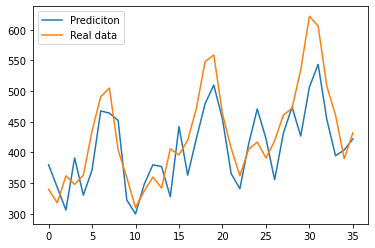

In [17]:
plt.plot(y_pred,label='Prediciton')
plt.plot(scaler.inverse_transform(y_test.reshape(1,-1))[0],label='Real data')
plt.legend()

4. \* Попробуйте улучшить качество предсказаний (и CNN, и LSTM), меняя следующие параметры:

- ширину окна $k$;
- ширину окна сверточного слоя и слоя субдискретизации;
- количество слоев;
- количество нейронов скрытого слоя и т.д.